In [2]:
# Step 1: Imports with updated modularized parsing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Use the same file path as in the first cell
results_cocoa_boolq = pd.read_csv("output/polygraph/CoCoaMSP/boolq_llama_3.2_3b_instruct_CocoaMSP_500.csv")
results_cocoa_boolq

,question,title,answer,passage,context,input_text,model_output,model_answer,uncertainty_score,ground_truth,match
0,is systemic functional grammar a contemporary ...,Systemic functional grammar,True,Systemic functional grammar (SFG) is a form of...,Systemic functional grammar (SFG) is a form of...,You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,? \nAnswer: yes,1.451507,True,False
1,is season 7 the final season of true blood,True Blood (season 7),True,The seventh and final season of the HBO supern...,The seventh and final season of the HBO supern...,You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,? \nAnswer: yes,0.832336,True,False
2,are there any of the temptations still living,Otis Williams,True,Williams is best known as the founder and last...,Williams is best known as the founder and last...,You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,? \nAnswer: yes,2.207614,True,False
3,does shaving your head make lice go away,Treatment of human head lice,True,Shaving the head or cutting the hair extremely...,Shaving the head or cutting the hair extremely...,You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,? \nAnswer: yes,1.988852,True,False
4,does a turtle's shell grow with them,Turtle shell,True,The carapacial ridge has been found to play an...,The carapacial ridge has been found to play an...,You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,?\nYes/No?,2.817971,True,False
...,...,...,...,...,...,...,...,...,...,...,...
495,do you get overseas service bars for korea,Overseas Service Bar,True,19-28. Overseas service bars a. Authorized wea...,19-28. Overseas service bars a. Authorized wea...,You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,? \nAnswer: yes,1.724264,True,False
496,does golden goal apply in the world cup 2018,Golden goal,False,"In February 2004, the IFAB announced that afte...","In February 2004, the IFAB announced that afte...",You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,? \nAnswer: no,0.951977,False,False
497,is it safe to swim in brisbane river,Brisbane River,False,"Environmentally, the river is in a poor condit...","Environmentally, the river is in a poor condit...",You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,waters? \nAnswer: no.,1.156085,False,False
498,is a certified abstract of birth a birth certi...,Birth certificate,True,The U.S. State Department has paid close atten...,The U.S. State Department has paid close atten...,You are a reading comprehension assistant. Giv...,UncertaintyOutput(uncertainty=4.80106163024902...,? \nAnswer: no.,1.874861,True,False


In [4]:
import re

# Extract yes/no from model_answer and convert to boolean
def extract_yes_no(text):
    # Search for first occurrence of yes or no (case insensitive)
    match = re.search(r'\b(yes|no)\b', str(text).lower())
    if match:
        return match.group(1) == 'yes'
    return None

# Extract uncertainty value from uncertainty_score
def extract_uncertainty(uncertainty_obj):
    # Convert to string and extract the number using regex
    uncertainty_str = str(uncertainty_obj)
    match = re.search(r'uncertainty=([\d.]+)', uncertainty_str)
    if match:
        return float(match.group(1))
    return None

# Create answer_parsed column
results_cocoa_boolq['answer_parsed'] = results_cocoa_boolq['model_answer'].apply(extract_yes_no)

# Re-evaluate match column based on answer_parsed vs answer
results_cocoa_boolq['match'] = results_cocoa_boolq['answer_parsed'] == results_cocoa_boolq['answer']

# Display the updated dataframe
results_cocoa_boolq[['question', 'answer', 'model_answer', 'answer_parsed', 'uncertainty_score', 'match']].head(15)

,question,answer,model_answer,answer_parsed,uncertainty_score,match
0,is systemic functional grammar a contemporary ...,True,? \nAnswer: yes,True,1.451507,True
1,is season 7 the final season of true blood,True,? \nAnswer: yes,True,0.832336,True
2,are there any of the temptations still living,True,? \nAnswer: yes,True,2.207614,True
3,does shaving your head make lice go away,True,? \nAnswer: yes,True,1.988852,True
4,does a turtle's shell grow with them,True,?\nYes/No?,True,2.817971,True
5,does dr house die in the last episode,False,of season 5? \nAnswer: yes,True,4.257132,False
6,is hair bleach the same as regular bleach,True,? \nAnswer: no.,False,1.886328,False
7,did zidane won la liga as a coach,True,? \nAnswer: yes,True,0.929258,True
8,has anyone won all 4 majors in the same year,True,since 1930? \nAnswer: no,False,3.067979,False
9,the kingdom of vijayanagar was found by two br...,True,. \nAnswer: yes.,True,1.166461,True


In [5]:
# Calculate the accuracy (match rate)
accuracy = results_cocoa_boolq['match'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.60%


In [6]:
# filter for uncertainty scores below 7 and calculate correlation
filtered_data = clean_data[clean_data['uncertainty_score'] < 7]
correlation = filtered_data['uncertainty_score'].corr(-filtered_data['match'].astype(int))
print(f"Correlation (filtered < 7): {correlation:.3f}")

NameError: name 'clean_data' is not defined

<Figure size 1000x600 with 0 Axes>

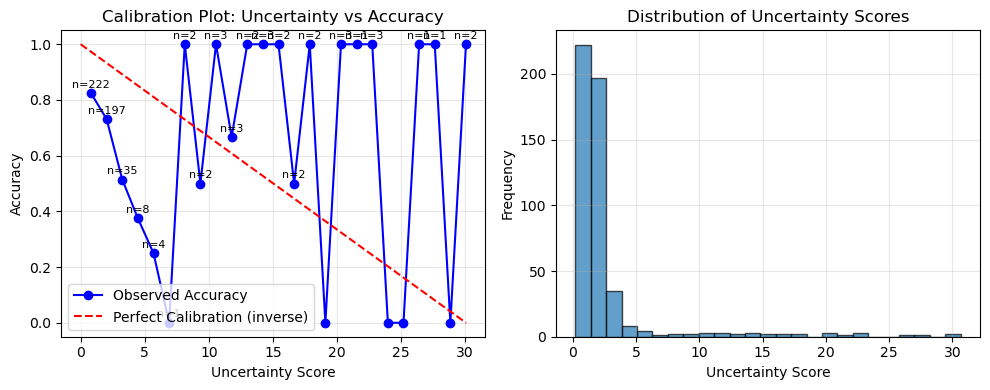

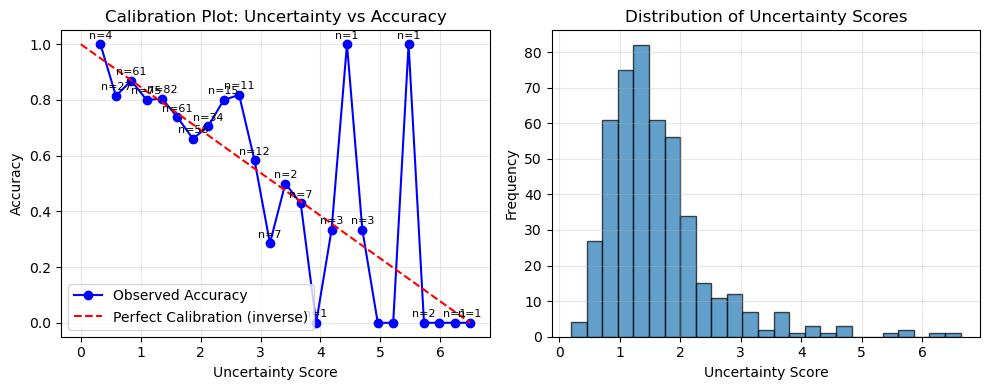

Correlation between uncertainty and correctness: -0.043
Mean uncertainty for correct answers: 2.68
Mean uncertainty for incorrect answers: 2.27


Correlation between uncertainty and correctness for filtered data: 0.257
Mean uncertainty for correct answers (filtered): 1.49
Mean uncertainty for incorrect answers (filtered): 2.01


In [15]:
# Create calibration plot for uncertainty vs correctness
plt.figure(figsize=(10, 6))

# Remove rows where answer_parsed is None for this analysis
clean_data = results_cocoa_boolq.dropna(subset=['answer_parsed'])

# filter for uncertainty scores below 7 and calculate correlation
filtered_data = clean_data[clean_data['uncertainty_score'] < 7]
correlation = filtered_data['uncertainty_score'].corr(-filtered_data['match'].astype(int))

# Continue with the analysis using filtered_data
# clean_data = filtered_data.copy()

# Create bins for uncertainty scores
n_bins = 25
bin_edges = np.linspace(clean_data['uncertainty_score'].min(), clean_data['uncertainty_score'].max(), n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate accuracy for each bin
bin_accuracies = []
bin_counts = []

for i in range(n_bins):
    # Find data points in this bin
    mask = (clean_data['uncertainty_score'] >= bin_edges[i]) & (clean_data['uncertainty_score'] < bin_edges[i+1])
    if i == n_bins - 1:  # Include right edge for last bin
        mask = (clean_data['uncertainty_score'] >= bin_edges[i]) & (clean_data['uncertainty_score'] <= bin_edges[i+1])
    
    bin_data = clean_data[mask]
    
    if len(bin_data) > 0:
        accuracy = bin_data['match'].mean()
        bin_accuracies.append(accuracy)
        bin_counts.append(len(bin_data))
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)

# Create bins for uncertainty scores
n_bins = 25
bin_edges_filtered = np.linspace(filtered_data['uncertainty_score'].min(), filtered_data['uncertainty_score'].max(), n_bins + 1)
bin_centers_filtered = (bin_edges_filtered[:-1] + bin_edges_filtered[1:]) / 2

# Calculate accuracy for each bin
bin_accuracies_filtered = []
bin_counts_filtered = []

for i in range(n_bins):
    # Find data points in this bin
    mask = (filtered_data['uncertainty_score'] >= bin_edges_filtered[i]) & (filtered_data['uncertainty_score'] < bin_edges_filtered[i+1])
    if i == n_bins - 1:  # Include right edge for last bin
        mask = (filtered_data['uncertainty_score'] >= bin_edges_filtered[i]) & (filtered_data['uncertainty_score'] <= bin_edges_filtered[i+1])
    
    bin_data = filtered_data[mask]
    
    if len(bin_data) > 0:
        accuracy = bin_data['match'].mean()
        bin_accuracies_filtered.append(accuracy)
        bin_counts_filtered.append(len(bin_data))
    else:
        bin_accuracies_filtered.append(0)
        bin_counts_filtered.append(0)

# First set
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Calibration plot
axes[0].plot(bin_centers, bin_accuracies, 'bo-', label='Observed Accuracy')
axes[0].plot([0, bin_centers.max()], [1, 0], 'r--', label='Perfect Calibration (inverse)')
axes[0].set_xlabel('Uncertainty Score')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Calibration Plot: Uncertainty vs Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for x, y, count in zip(bin_centers, bin_accuracies, bin_counts):
    if count > 0:
        axes[0].text(x, y + 0.02, f'n={count}', ha='center', fontsize=8)

# Histogram
axes[1].hist(clean_data['uncertainty_score'], bins=n_bins, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Uncertainty Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Uncertainty Scores')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Second set (filtered data)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Calibration plot
axes[0].plot(bin_centers_filtered, bin_accuracies_filtered, 'bo-', label='Observed Accuracy')
axes[0].plot([0, bin_centers_filtered.max()], [1, 0], 'r--', label='Perfect Calibration (inverse)')
axes[0].set_xlabel('Uncertainty Score')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Calibration Plot: Uncertainty vs Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for x, y, count in zip(bin_centers_filtered, bin_accuracies_filtered, bin_counts_filtered):
    if count > 0:
        axes[0].text(x, y + 0.02, f'n={count}', ha='center', fontsize=8)

# Histogram
axes[1].hist(filtered_data['uncertainty_score'], bins=n_bins, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Uncertainty Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Uncertainty Scores')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Print summary statistics
print(f"Correlation between uncertainty and correctness: {clean_data['uncertainty_score'].corr(-clean_data['match'].astype(int)):.3f}")
print(f"Mean uncertainty for correct answers: {clean_data[clean_data['match']]['uncertainty_score'].mean():.2f}")
print(f"Mean uncertainty for incorrect answers: {clean_data[~clean_data['match']]['uncertainty_score'].mean():.2f}\n\n")

print(f"Correlation between uncertainty and correctness for filtered data: {filtered_data['uncertainty_score'].corr(-filtered_data['match'].astype(int)):.3f}")
print(f"Mean uncertainty for correct answers (filtered): {filtered_data[filtered_data['match']]['uncertainty_score'].mean():.2f}")
print(f"Mean uncertainty for incorrect answers (filtered): {filtered_data[~filtered_data['match']]['uncertainty_score'].mean():.2f}")

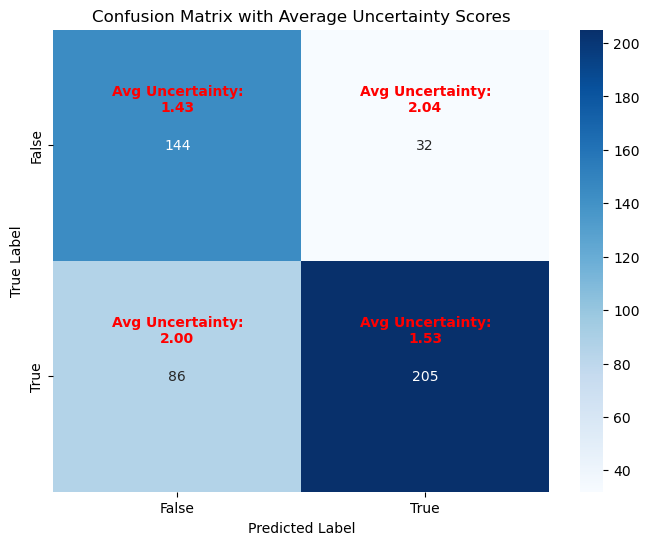

True Negatives (TN): 144 - Avg Uncertainty: 1.43
False Positives (FP): 32 - Avg Uncertainty: 2.04
False Negatives (FN): 86 - Avg Uncertainty: 2.00
True Positives (TP): 205 - Avg Uncertainty: 1.53


In [76]:
from sklearn.metrics import confusion_matrix

# Convert answer_parsed to boolean type
clean_data['answer_parsed'] = clean_data['answer_parsed'].astype(bool)

# Create confusion matrix
y_true = clean_data['answer']
y_pred = clean_data['answer_parsed']

cm = confusion_matrix(y_true, y_pred)

# Calculate average uncertainty for each quadrant
tn_uncertainty = clean_data[(clean_data['answer'] == False) & (clean_data['answer_parsed'] == False)]['uncertainty_score'].mean()
fp_uncertainty = clean_data[(clean_data['answer'] == False) & (clean_data['answer_parsed'] == True)]['uncertainty_score'].mean()
fn_uncertainty = clean_data[(clean_data['answer'] == True) & (clean_data['answer_parsed'] == False)]['uncertainty_score'].mean()
tp_uncertainty = clean_data[(clean_data['answer'] == True) & (clean_data['answer_parsed'] == True)]['uncertainty_score'].mean()

# Create the confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])

# Add uncertainty annotations
plt.text(0.5, 0.3, f'Avg Uncertainty:\n{tn_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(1.5, 0.3, f'Avg Uncertainty:\n{fp_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(0.5, 1.3, f'Avg Uncertainty:\n{fn_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(1.5, 1.3, f'Avg Uncertainty:\n{tp_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')

plt.title('Confusion Matrix with Average Uncertainty Scores')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print detailed statistics
print(f"True Negatives (TN): {cm[0,0]} - Avg Uncertainty: {tn_uncertainty:.2f}")
print(f"False Positives (FP): {cm[0,1]} - Avg Uncertainty: {fp_uncertainty:.2f}")
print(f"False Negatives (FN): {cm[1,0]} - Avg Uncertainty: {fn_uncertainty:.2f}")
print(f"True Positives (TP): {cm[1,1]} - Avg Uncertainty: {tp_uncertainty:.2f}")